In [1]:
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pydiffmap import diffusion_map as dm
from scaccordion import tl
import networkx as nx
from sklearn.preprocessing import Normalizer
import warnings
import ot
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from sklearn import manifold
from scipy.linalg import  norm
import phate
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
import sci_palettes
from tqdm import tqdm
import kmedoids
import random
import itertools as it
np.random.seed(859)

warnings.filterwarnings("ignore")


2024-03-19 11:11:50.705769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 11:11:50.705793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 11:11:50.706453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 11:11:51.231498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
dt="Peng_PDAC_processed_data_tmm_final.pickle"
path = '/home/james/icg/scRNA/Patients_scRNA/eccb2/'
print(dt)
f = open(path+dt,'rb')
dtset = dt.replace('_processed','').replace('.pickle','').replace('_data','').replace('_tmm_final','')
metadata = pd.read_hdf(f"~/icg/scRNA/Patients_scRNA/data/metadata/{dtset}_metaacc.h5ad")
Aaccdt = pickle.load(f)
labels=metadata.loc[Aaccdt.p.columns,'accLabel']

Peng_PDAC_processed_data_tmm_final.pickle


In [3]:
km = kmedoids.KMedoids(n_clusters=3, method='fasterpam')
plt.figure(figsize=(6,5))
c = km.fit(Aaccdt.wdist['HTD_0.5'].to_numpy())
X =np.round(Aaccdt.wdist['HTD_0.5'].loc[Aaccdt.wdist['HTD_0.5'].index,Aaccdt.wdist['HTD_0.5'].index],5)
clust,loss = [],[]
for _ in tqdm(range(100)):
    kmeans = tl.KBarycenters(k=3,init='++',random_state=42,max_iters=100)
    kmeans.fit(X,distr=Aaccdt.p,cost=Aaccdt.Cs['HTD_0.5'])
    clust.append(kmeans)
    loss.append(kmeans.centroids.mean().mean())
ncls= clust[np.argmin(loss)]

100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


<Figure size 600x500 with 0 Axes>

In [4]:
aux = ncls.centroids.to_dict()
for i in range(3):
    for j in range(i,3):
        if i!=j:
            aux[i][j] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=Aaccdt.Cs['HTD_0.5'])
            aux[j][i] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=Aaccdt.Cs['HTD_0.5'])
        else:
            aux[i][j] = 0
eux = pd.concat([Aaccdt.wdist['HTD_0.5'],ncls.centroids],axis=1)
eux = pd.concat([eux,pd.DataFrame.from_dict(aux).T])
tmplab = ncls.flabels.tolist()
for i in [0,1,2]:
    tmplab.append(i) 

In [5]:
tmpstl = ['0']*len(Aaccdt.p.columns)+['1']*3

In [6]:
emb1 = manifold.MDS(dissimilarity='precomputed',random_state=42)
emb1 = emb1.fit_transform(eux)

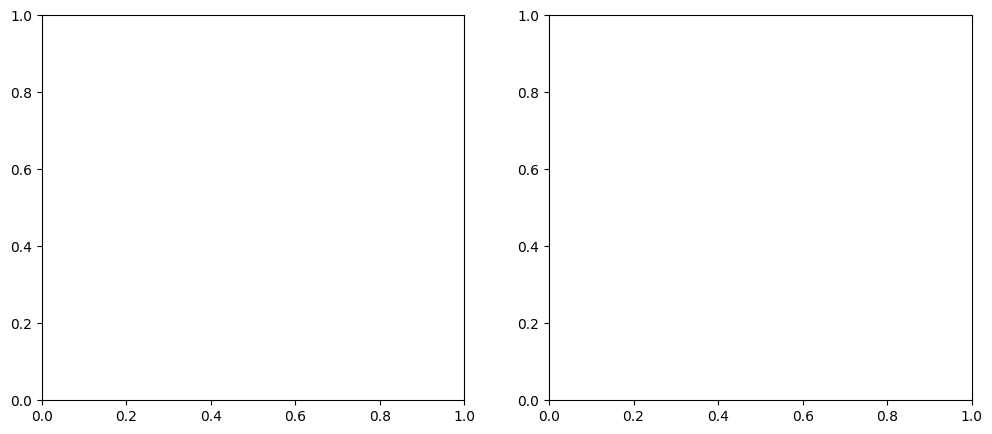

In [7]:
fs,axs = plt.subplots(1,2,figsize=(12,5))
axs = axs.ravel()

## Clustering

In [8]:
barys = pd.DataFrame(ncls.bary,index=Aaccdt.p.index)
barys.reset_index(inplace=True)
barys[['u', 'v']] = barys['index'].str.split('$', expand=True)
cmapse =[plt.cm.Greens,plt.cm.Blues,plt.cm.Reds]
vtxcmap = {i[1]:plt.cm.tab10.colors[i[0]] for i in enumerate(Aaccdt.nodes)}

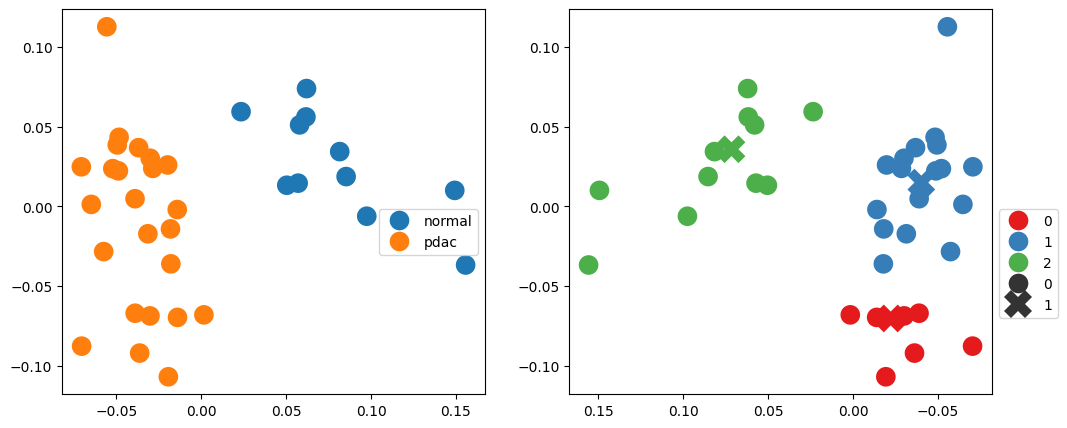

In [9]:
sns.scatterplot(x=emb1[0:-3,0],
                y=emb1[0:-3,1],hue=labels,s=200,linewidth=0,ax=axs[0])
axs[0].legend(loc=0, bbox_to_anchor=(1, 0.5))
sns.scatterplot(x=emb1[:,0],
                y=emb1[:,1],hue=tmplab,s=200,style=tmpstl,palette=list(plt.cm.Set1.colors)[0:3],
                size=tmpstl,sizes=(400,200),linewidth=0,ax=axs[1])
axs[1].legend(loc=0, bbox_to_anchor=(1, 0.5))
axs[1].invert_xaxis()
#fs.savefig("../PDAC_Resuls_CC/PDAC_MDS.pdf")
fs

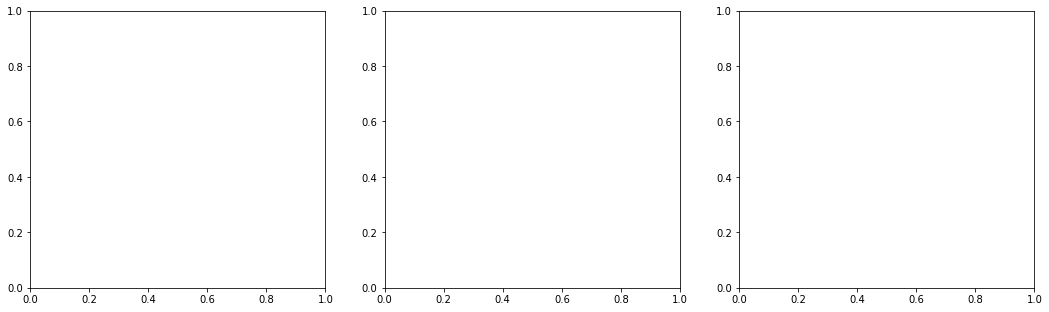

In [10]:
fs,axs = plt.subplots(1,3,figsize=(18,5),dpi=72)
axs = axs.ravel()

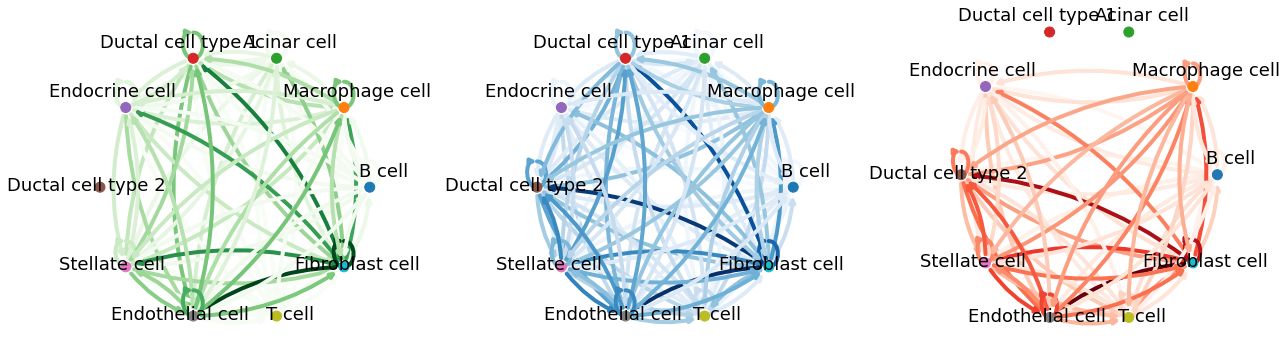

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [11]:
cnt=0
for i in [2,1,0]:
    barynet =nx.from_pandas_edgelist(barys[barys[i]>1e-5].sort_values(i,ascending=True),
                            source='u',
                            target='v',
                            edge_attr=i,
                            create_using=nx.DiGraph)
    tempnet = nx.complete_graph(len(Aaccdt.nodes),create_using=nx.DiGraph)
    pos = nx.circular_layout(tempnet,scale=2)
    pos = {list(Aaccdt.nodes)[i[0]]:i[1] for i in enumerate(pos.values())}
    for id1 in Aaccdt.nodes:
        if  id1 not in barynet.nodes():
            barynet.add_node(id1)
    plt.figure(figsize=(5,5))
    currcmap = [vtxcmap[u] for u in barynet.nodes()]
    nx.draw_networkx_nodes(barynet,pos,node_size=100,node_color=currcmap,ax=axs[cnt])
    edcol = nx.get_edge_attributes(barynet,i)
    nx.draw_networkx_edges(barynet,pos=pos,edge_color=edcol.values(),
                           connectionstyle="arc3,rad=0.15",
                           edge_cmap=cmapse[::-1][i],width=4,ax=axs[cnt])
    for k,v in pos.items():
        v[1]+=np.sign(v[1])*0.1
        v[0]+=np.sign(v[0])*0.2
    nx.draw_networkx_labels(barynet,pos,verticalalignment='bottom',
                            font_size=18,clip_on=False,ax=axs[cnt])
    axs[cnt].axis('off')
    cnt+=1
    #plt.savefig(f'bary_{i}.pdf')
fs.tight_layout()
fs
#fs.savefig("../PDAC_Resuls_CC/ccis.pdf")

In [12]:
ctrb2pdac1 = ot.emd(a=barys[2].to_numpy()/barys[2].sum(),
       b=barys[0].to_numpy()/barys[0].sum(),M=Aaccdt.Cs['HTD_0.5'])
pdac12pdac2 = ot.emd(a=barys[2].to_numpy()/barys[2].sum(),
       b=barys[1].to_numpy()/barys[1].sum(),M=Aaccdt.Cs['HTD_0.5'])

In [13]:
ctrb2pdac1 = ctrb2pdac1/ctrb2pdac1.max()
pdac12pdac2 = pdac12pdac2/pdac12pdac2.max()

In [14]:
def sel(x,n):
    end=((n**2)+n)/2
    print(end)
    return x[0:int(end)]

In [15]:
tmaps = pd.DataFrame.from_records([sel(ctrb2pdac1.ravel(),len(Aaccdt.p)),
                                   sel(pdac12pdac2.ravel(),len(Aaccdt.p))]).T
tmaps.index=list(it.combinations_with_replacement(Aaccdt.p.index,2))
tmaps.columns = ['ctr->PDAC1','PDAC1->PDAC2']
tmaps = tmaps[tmaps.sum(axis=1)!=0]
tmaps=tmaps.reset_index()
tmaps[['edge1','edge2']] = pd.DataFrame(tmaps['index'].tolist())
tmaps[['source1','target1']] = tmaps['edge1'].str.split('$',expand=True)
tmaps[['source2','target2']] = tmaps['edge2'].str.split('$',expand=True)


5050.0
5050.0


In [16]:
#tmaps.to_csv("../PDAC_Resuls_CC/tmaps.csv")

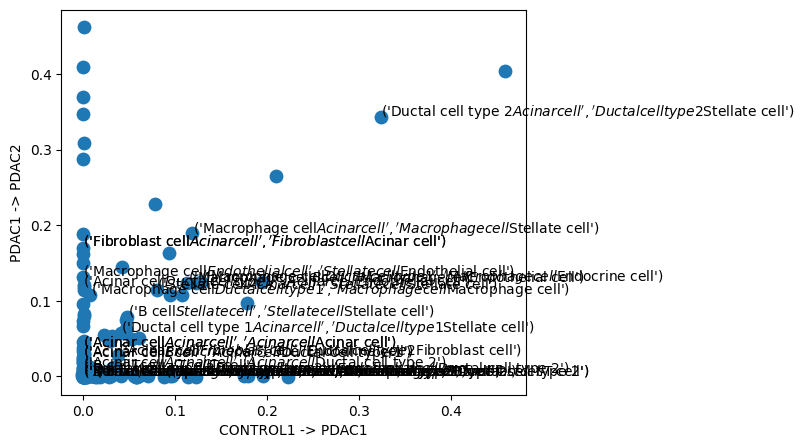

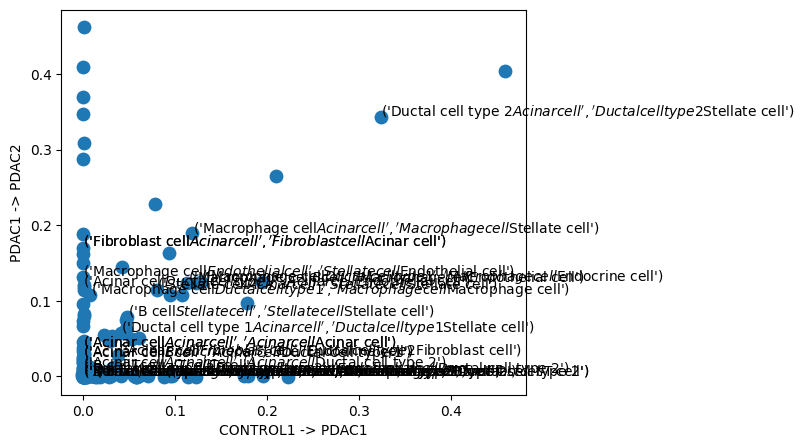

In [17]:
f,axs1 = plt.subplots(1,1,figsize=(6 ,5))
sns.regplot(x="ctr->PDAC1",y="PDAC1->PDAC2",data=tmaps,fit_reg = False,
           x_jitter = 0.001, y_jitter = 0.001, scatter_kws = {'alpha' : 1,'s':80},ax=axs1)
n=10
ssource = tmaps.loc[tmaps['source1']==tmaps['source2'],:].sort_values("ctr->PDAC1",ascending=False)
starget =  tmaps.loc[tmaps['target1']==tmaps['target2'],:].sort_values("PDAC1->PDAC2",ascending=False)

def ann(row):
    r = row[1]
    ind = r["index"]
    axs1.annotate(ind, xy=(r["ctr->PDAC1"], r["PDAC1->PDAC2"]), 
            xytext=(0.1,0.1) , textcoords ="offset points")

for row in ssource.iterrows():
    ann(row)
for row in starget.iterrows():
    ann(row)
axs1.set_xlabel('CONTROL1 -> PDAC1')
axs1.set_ylabel('PDAC1 -> PDAC2')
f
#f.savefig('../PDAC_Resuls_CC/tmap1.pdf')

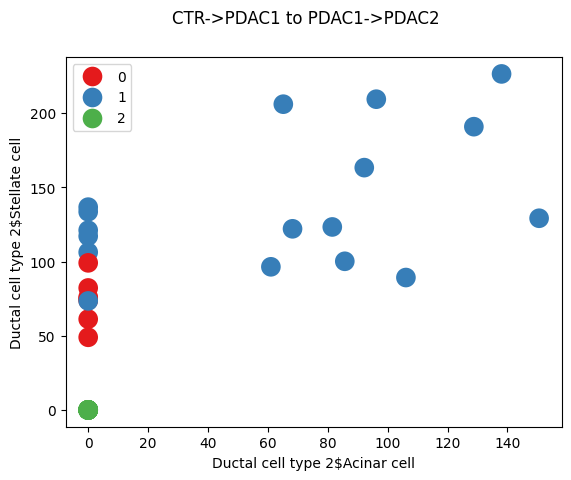

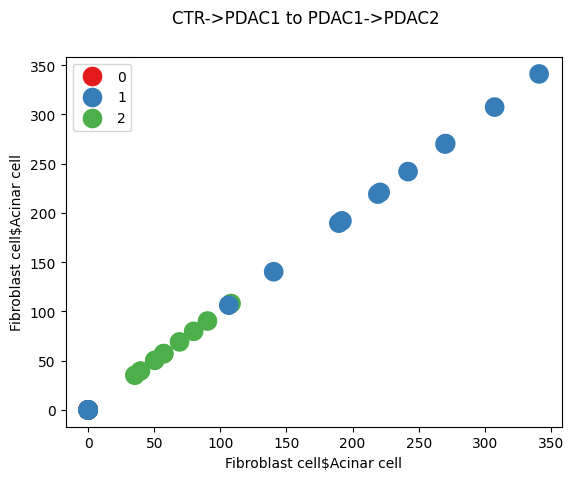

In [19]:
for i in ssource.iterrows():
    plt.figure()
    sns.scatterplot(x=i[1]['edge1'],y=i[1]['edge2'],
                    data=Aaccdt.p.T,hue=tmplab[0:-3],
                    palette=list(plt.cm.Set1.colors)[0:3],s=200,linewidth=0)
    plt.suptitle('CTR->PDAC1 to PDAC1->PDAC2')
    break
    #plt.savefig(f"../PDAC_Resuls_CC/same_source/1-{i[1]['index']}.pdf")
for i in starget.iterrows():
    plt.figure()
    sns.scatterplot(x=i[1]['edge1'],y=i[1]['edge2'],
                    data=Aaccdt.p.T,hue=tmplab[0:-3],
                    palette=list(plt.cm.Set1.colors)[0:3],s=200,linewidth=0)
    plt.suptitle('CTR->PDAC1 to PDAC1->PDAC2')
    break
    #plt.savefig(f"../PDAC_Resuls_CC/same_target/1-{i[1]['index']}.pdf")

In [20]:
ncls.flabels

array([0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 1, 1,
       2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1])

In [21]:
lab = ['PDAC2',"PDAC1","CONTROL"]

In [22]:
nlabels = {k:lab[v] for k,v in zip(Aaccdt.wdist['HTD_0.5'].index,ncls.flabels)}

In [23]:
import scanpy as sc

In [24]:
scadata = sc.read_h5ad("/home/james/icg/scRNA/Patients_scRNA/data/singlecell_processed/Peng_PDAC_processed.h5ad")

In [25]:
scadata.obs['kbary'] = [nlabels[i] for i in scadata.obs['orig.ident']]

# 

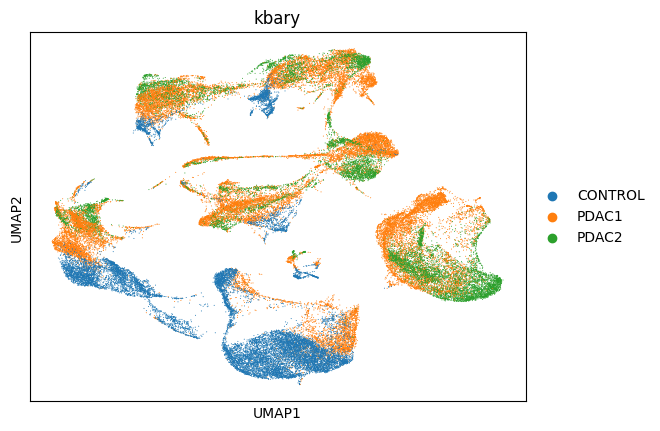

In [26]:
sc.pl.umap(scadata,color='kbary')

In [ ]:
import liana as li

In [ ]:
for i in lab:
    lr=li.method.cellphonedb(scadata[scadata.obs.kbary==i], 
                                  groupby='accAnnot', 
                                  expr_prop=0.15, 
                                  verbose=False,
                                  resource_name='consensus',inplace=False,use_raw=False)
    lr.to_csv(f"PDAC_Resuls_CC/lr_{i}.csv")


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
#utils = rpackages.importr('utils')
#devtools = utils.install_packages('devtools')
d = {'package.dependencies': 'package_dot_dependencies',
     'package_dependencies': 'package_uscore_dependencies'}
ctker = importr('CrossTalkeR', 
           robject_translations = d)
data = {}
for i in os.listdir('PDAC_Resuls_CC/'):
    if i.startswith('lr') and i.endswith('csv'):
        evfull = pd.read_csv('PDAC_Resuls_CC/'+i)
        evfull = evfull.loc[:,['ligand','receptor','source','target','lr_means','cellphone_pvals']]
        evfull['type_gene_A'] = 'Ligand'
        evfull['type_gene_B'] = 'Receptor'
        evfull['gene_A'] = evfull['ligand']
        evfull['gene_B'] = evfull['receptor']
        evfull['MeanLR'] = evfull['lr_means']
        k=i[i.find('|')+1:len(i)-4]
        evfull.loc[list(evfull.cellphone_pvals.to_numpy()<=0.01),:].to_csv(f'PDAC_Resuls_CC/ct_{i}')
        data[k]=os.path.abspath(f'PDAC_Resuls_CC/ct_{i}')
an = ro.ListVector(data)

In [ ]:

aux = ctker.generate_report(lrpaths=an.rx(ro.r("c('lr_CONTROL','lr_PDAC1','lr_PDAC2')")),
                out_path="/home/james/sciebo/PDAC_Resuls_CC/",threshold = 0,
                out_file = 'control.html',
                output_fmt = "html_document",
                report=True,
                org = 'hsa')


In [ ]:

aux = ctker.generate_report(lrpaths=an.rx(ro.r("c('lr_PDAC2','lr_PDAC1')")),
                out_path="/home/james/sciebo/PDAC_Resuls_CC/PDAC1vsPDAC2/",threshold = 0,
                out_file = 'control.html',
                output_fmt = "html_document",
                report=True,
                org = 'hsa')

In [ ]:
%load_ext rpy2.ipython


In [ ]:
%%R
require(CrossTalkeR)
require(ggplot2)
ctrpdac1 <- readRDS("../PDAC_Resuls_CC/CTRL+/LR_data_final.Rds")
ctrpdac2 <- readRDS("../PDAC_Resuls_CC/PDAC1vsPDAC2/LR_data_final.Rds")


In [ ]:
%%R
p1<-plot_sankey(ctrpdac1@tables$lr_PDAC1_x_lr_CONTROL,ligand_cluster='Ductal cell type 2',
                                               receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("CTR->PDAC1")
p2<-plot_sankey(ctrpdac1@tables$lr_PDAC2_x_lr_CONTROL,ligand_cluster='Ductal cell type 2',
                                               receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("CTR->PDAC2")
p3<-plot_sankey(ctrpdac2@tables$lr_PDAC1_x_lr_PDAC2,ligand_cluster='Ductal cell type 2',
                                                receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("PDAC2->PDAC1")
p1+p2+p3
ggsave("../PDAC_Resuls_CC/sankey/MalignantDuctal2Stellate_top5.pdf",width=25,height=7)

In [ ]:
%%R
p1<-plot_sankey(ctrpdac1@tables$lr_PDAC1_x_lr_CONTROL,ligand_cluster='Ductal cell type 2',
                                               receptor_cluster="Acinar cell",threshold=20)+
                ggtitle("CTR->PDAC1")
p3<-plot_sankey(ctrpdac2@tables$lr_PDAC1_x_lr_PDAC2,ligand_cluster='Ductal cell type 2',
                                                receptor_cluster="Acinar cell",threshold=20)+
                ggtitle("PDAC2->PDAC1")
p1+p3
ggsave("../PDAC_Resuls_CC/sankey/MalignantDuctal2Acinar_top5.pdf",width=25,height=7)

In [ ]:
%%R
p1<-plot_sankey(ctrpdac1@tables$lr_PDAC1_x_lr_CONTROL,ligand_cluster='Macrophage cell',
                                               receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("CTR->PDAC1")
p2<-plot_sankey(ctrpdac1@tables$lr_PDAC2_x_lr_CONTROL,ligand_cluster='Macrophage cell',
                                               receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("CTR->PDAC2")
p3<-plot_sankey(ctrpdac2@tables$lr_PDAC1_x_lr_PDAC2,ligand_cluster='Macrophage cell',
                                               receptor_cluster="Stellate cell",threshold=20)+
                ggtitle("PDAC2->PDAC1")
p1+p2+p3
ggsave("../PDAC_Resuls_CC/sankey/Macs2Stellate_top5.pdf",width=25,height=7)


In [ ]:
%%R
p1<-plot_sankey(ctrpdac1@tables$lr_PDAC1_x_lr_CONTROL,ligand_cluster='Macrophage cell',
                                               receptor_cluster="Acinar cell",threshold=20)+
                ggtitle("CTR->PDAC1")
p2<-plot_sankey(ctrpdac1@tables$lr_PDAC2_x_lr_CONTROL,ligand_cluster='Macrophage cell',
                                               receptor_cluster="Acinar cell",threshold=20)+
                ggtitle("CTR->PDAC2")

p1+p2
ggsave("../PDAC_Resuls_CC/sankey/Mac2Acinar_top5.pdf",width=25,height=7)

In [ ]:
scadata.obs.accAnnot

In [ ]:
sc.pl.violin(scadata[scadata.obs.accAnnot=='Ductal cell type 2'],keys=['FN1',"COL1A1",'PDGFC'],
             groupby='kbary',stripplot=False,save=True)
#plt.savefig('../PDAC_Resuls_CC/violin1.pdf')

In [ ]:
sc.pl.violin(scadata[scadata.obs.accAnnot=='Ductal cell type 2'],keys=['LGALS1','LGALS3','PDAP1'],
             groupby='kbary',stripplot=False,save=True)